<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ резюме из HeadHunter
   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [2]:
# Функции

def level_edu(elem):
    '''Извлечение уровня образования из строки

    Args:
        elem (str): Заданная строка  признака "Образование и ВУЗ"

    Returns:
        str: Уровень образования ("высшее", "неоконченное высшее", "среднее специальное" и "среднее")
        None: Если искомого уровня образования не найдено
    '''
    
    # Получаем список слов из строки
    elem = elem.lower().split(' ')
    try:
        # вычисляем индекс слова 'образование'
        i = elem.index('образование')
    except ValueError:
        return None
    return ' '.join(elem[:i])


def gender(elem):
    '''Извлечение пола соискателя из строки

    Args:
        elem (str): Заданная строка  признака "Пол, возраст"

    Returns:
        str: Пол ("М", "Ж")
        None: Если искомой информации не найдено
    '''
    
    # Получаем список выражений из строки
    elem = elem.lower().split(' , ')
    if elem[0] == 'мужчина':
        gender = 'М'
    elif elem[0] == 'женщина':
        gender = 'Ж'
    else:
        gender = None
    return gender


def age(elem):
    '''Извлечение возраста из строки

    Args:
        elem (str): Заданная строка  признака "Пол, возраст"

    Returns:
        int: Возраст
        None: Если искомой информации не найдено
    '''
    
    # Получаем список выражений из строки
    elem = elem.lower().split(' , ')
    try:
        age = int(elem[1].split()[0])
    except ValueError:
        age = None
    return age


def experience(elem):
    '''Извлечение опыта работы из строки и преобразование его в месяцы

    Args:
        elem (str): Заданная строка  признака "Опыт работы"

    Returns:
        int: Опыт работы в месяцах
        NaN: Если опыт работы не уазан
    '''
    
    try:
        # Получаем список выражений из строки
        elem_lst = elem.split()
        # Рассчитываем количество месяцев работы
        if elem_lst[3] in ['месяц', 'месяца', 'месяцев']:
            result = int(elem_lst[2])
        elif (elem_lst[3] in ['год', 'года', 'лет']) and (elem_lst[5] in ['месяц', 'месяца', 'месяцев']):
            result = int(elem_lst[2])*12 + int(elem_lst[4])
        elif elem_lst[3] in ['год', 'года', 'лет']:
            result = int(elem_lst[2])*12
        else:
            # Если года или месяцы указаны с ошибкой возвращаем np.nan
            result = np.nan
    # Если не смогли рассчитать (пустое значение или текст в ячейке) возвращаем np.nan
    except IndexError:
        return np.nan
    except ValueError:
        return np.nan
    except AttributeError:
        return np.nan
    return result


def get_city(elem):
    '''Извлечение Города проживания соискателя

    Args:
        elem (str): Заданная строка  признака "Город, переезд, командировки"

    Returns:
        str: Город проживания соискателя ("Москва", "Санкт-Петербург", "город-миллионник", "другие")        
    '''
    
    # Список городов-миллионников:
    million_cities = ['новосибирск', 'екатеринбург','нижний новгород','казань', 'челябинск', 'омск',
                      'самара', 'ростов-на-дону', 'уфа', 'красноярск', 'пермь', 'воронеж','волгоград'
    ]
    # Получаем список выражений из строки
    elem_lst = elem.lower().split(' , ')
    # Выделяем город (отбасывая область)
    city = elem_lst[0].split()[0]
    if city == 'москва':
        return 'Москва'
    elif city == 'санкт-петербург':
        return 'Санкт-Петербург'
    elif city in million_cities:
        return 'город-миллионник'
    else:
        return 'другие'


def relocation(elem):
    '''Определение готовности к переезду соискателя

    Args:
        elem (str): Заданная строка  признака "Город, переезд, командировки"

    Returns:
        bool: Признак готовности к переезду (True, False)        
    '''
    
    # Список маркеров:
    mark = ['не', 'готов', 'готова', 'хочу']
    mark_redy = ['готов', 'готова', 'хочу']
    # Получаем список выражений из строки
    elem_lst = elem.lower().split(' , ')
    # Выделяем готовность к переезду
    city = elem_lst[1].split()[0]
    #Отстраиваемся от локации метро
    if city not in mark:
        city = elem_lst[2].split()[0]
    if city in mark_redy:
        return True
    else:
        return False


def business_trip(elem):
    '''Определение готовности к командировкам соискателя

    Args:
        elem (str): Заданная строка  признака "Город, переезд, командировки"

    Returns:
        bool: Признак готовности к командировкам (True, False)        
    '''
    
    # Список маркеров:
    mark_redy = ['готов', 'готова']
    # Получаем список выражений из строки
    elem_lst = elem.lower().split(' , ')
    # Выделяем готовность к переезду
    redy = None
    for element in elem_lst:
        # Получаем список слов из строки
        words = element.split()
        if 'командировкам' not in words:
            continue
        if words[0] in mark_redy:
            redy = True
            break
        else:
            redy = False
            break
    # Если не нашли запись о командировках
    if not redy:
        redy = False
    return redy


def outliers_z_score_mod(data, feature, log_scale=False, left=3, right=3):
    '''Функция реализующая алгоритм метода z-отклонения

    Args:
        data (DataFrame): DataFrame содержащий признак, по которому ищутся выбросы
        feature (str): Признак, по которому ищутся выбросы
        log_scale (bool, optional): True - логарифмировать рассматриваемый признак,
                                    False - оставляем его в исходном виде.
                                    Defaults to False.
        left (int, optional): Число сигм (стандартных отклонений) влево,
                              определяющее границы метода z-отклонения.
                              Defaults to 3.
        right(int, optional): Число сигм (стандартных отклонений) вправо,
                              определяющее границы метода z-отклонения.
                              Defaults to 3.

    Returns:
        outliers (DataFrame): Возвращет выбросы
        cleaned (DataFrame):  Возвращает очищенные от выбросов данные
    '''
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

# Исследование структуры данных

1. Прочитайте данные с помощью библиотеки Pandas. Совет: перед чтением обратите внимание на разделитель внутри файла. 

In [3]:
resume_hh = pd.read_csv('data/dst-3.0_16_1_hh_database.csv', sep=';')
display(resume_hh.shape)

(44744, 12)

2. Выведите несколько первых (последних) строк таблицы, чтобы убедиться в том, что ваши данные не повреждены. Ознакомьтесь с признаками и их структурой.

In [4]:
display(resume_hh.head(5))
display(resume_hh.tail(5))

,"Пол, возраст",ЗП,Ищет работу на должность:,"Город, переезд, командировки",Занятость,График,Опыт работы,Последнее/нынешнее место работы,Последняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,"Мужчина , 39 лет , родился 27 ноября 1979",29000 руб.,Системный администратор,"Советск (Калининградская область) , не готов к...","частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, ва...",Опыт работы 16 лет 10 месяцев Август 2010 — п...,"МАОУ ""СОШ № 1 г.Немана""",Системный администратор,Неоконченное высшее образование 2000 Балтийск...,16.04.2019 15:59,Имеется собственный автомобиль
1,"Мужчина , 60 лет , родился 20 марта 1959",40000 руб.,Технический писатель,"Королев , не готов к переезду , готов к редким...","частичная занятость, проектная работа, полная ...","гибкий график, полный день, сменный график, уд...",Опыт работы 19 лет 5 месяцев Январь 2000 — по...,Временный трудовой коллектив,"Менеджер проекта, Аналитик, Технический писатель",Высшее образование 1981 Военно-космическая ак...,12.04.2019 08:42,Не указано
2,"Женщина , 36 лет , родилась 12 августа 1982",20000 руб.,Оператор,"Тверь , не готова к переезду , не готова к ком...",полная занятость,полный день,Опыт работы 10 лет 3 месяца Октябрь 2004 — Де...,ПАО Сбербанк,Кассир-операционист,Среднее специальное образование 2002 Профессио...,16.04.2019 08:35,Не указано
3,"Мужчина , 38 лет , родился 25 июня 1980",100000 руб.,Веб-разработчик (HTML / CSS / JS / PHP / базы ...,"Саратов , не готов к переезду , готов к редким...","частичная занятость, проектная работа, полная ...","гибкий график, удаленная работа",Опыт работы 18 лет 9 месяцев Август 2017 — Ап...,OpenSoft,Инженер-программист,Высшее образование 2002 Саратовский государст...,08.04.2019 14:23,Не указано
4,"Женщина , 26 лет , родилась 3 марта 1993",140000 руб.,Региональный менеджер по продажам,"Москва , не готова к переезду , готова к коман...",полная занятость,полный день,Опыт работы 5 лет 7 месяцев Региональный мене...,Мармелад,Менеджер по продажам,Высшее образование 2015 Кгу Психологии и педаг...,22.04.2019 10:32,Не указано


,"Пол, возраст",ЗП,Ищет работу на должность:,"Город, переезд, командировки",Занятость,График,Опыт работы,Последнее/нынешнее место работы,Последняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
44739,"Мужчина , 30 лет , родился 17 января 1989",50000 руб.,"Финансист, аналитик, экономист, бухгалтер, мен...","Тверь , готов к переезду (Москва, Химки) , гот...",полная занятость,"полный день, удаленная работа","Опыт работы 7 лет 7 месяцев Финансист, аналит...","ООО ""IAS"" (независимый участник объединения Ru...",Руководитель субгруппы,Высшее образование 2015 Московский гуманитарн...,22.04.2019 12:32,Не указано
44740,"Мужчина , 27 лет , родился 5 марта 1992",39000 руб.,"Системный администратор, IT-специалист","Липецк , готов к переезду , готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день, ...","Опыт работы 7 лет Системный администратор, IT...",ИП Пестрецов,Предприниматель,Высшее образование (Бакалавр) 2016 Воронежски...,22.04.2019 13:11,Не указано
44741,"Женщина , 48 лет , родилась 26 декабря 1970",40000 руб.,"Аналитик данных, Математик","Челябинск , готова к переезду , готова к редки...",полная занятость,"полный день, удаленная работа",Опыт работы 21 год 5 месяцев Январь 1998 — по...,"ОАО «ЧМК», Исследовательско-Технологический Це...",Начальник группы аналитики,Высшее образование 2000 Южно-Уральский госуда...,09.04.2019 05:07,Не указано
44742,"Мужчина , 24 года , родился 6 октября 1994",20000 руб.,Контент-менеджер,"Тамбов , не готов к переезду , не готов к кома...","частичная занятость, полная занятость",удаленная работа,Опыт работы 3 года 10 месяцев Контент-менедже...,IQ-Maxima,Менеджер проектов,Высшее образование 2015 Тамбовский государств...,26.04.2019 14:25,Имеется собственный автомобиль
44743,"Мужчина , 38 лет , родился 25 апреля 1980",120000 руб.,Руководитель проекта,"Москва , не готов к переезду , не готов к кома...",полная занятость,полный день,Опыт работы 15 лет 10 месяцев Руководитель пр...,ПАО ГК ТНС энерго,Руководитель отдела технической поддержки,Высшее образование 1997 Южно-Российский госуд...,05.07.2018 20:15,Не указано


3. Выведите основную информацию о числе непустых значений в столбцах и их типах в таблице.

4. Обратите внимание на информацию о числе непустых значений.

In [5]:
display(resume_hh.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44744 entries, 0 to 44743
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Пол, возраст                     44744 non-null  object
 1   ЗП                               44744 non-null  object
 2   Ищет работу на должность:        44744 non-null  object
 3   Город, переезд, командировки     44744 non-null  object
 4   Занятость                        44744 non-null  object
 5   График                           44744 non-null  object
 6   Опыт работы                      44576 non-null  object
 7   Последнее/нынешнее место работы  44743 non-null  object
 8   Последняя/нынешняя должность     44742 non-null  object
 9   Образование и ВУЗ                44744 non-null  object
 10  Обновление резюме                44744 non-null  object
 11  Авто                             44744 non-null  object
dtypes: object(12)
memory usage: 4.1+

None

5. Выведите основную статистическую информацию о столбцах.


In [6]:
display(resume_hh.describe())

,"Пол, возраст",ЗП,Ищет работу на должность:,"Город, переезд, командировки",Занятость,График,Опыт работы,Последнее/нынешнее место работы,Последняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
count,44744,44744,44744,44744,44744,44744,44576,44743,44742,44744,44744,44744
unique,16003,690,14929,10063,38,47,44413,30214,16927,40148,18838,2
top,"Мужчина , 32 года , родился 17 сентября 1986",50000 руб.,Системный администратор,"Москва , не готов к переезду , не готов к кома...",полная занятость,полный день,Опыт работы 10 лет 8 месяцев Апрель 2018 — по...,Индивидуальное предпринимательство / частная п...,Системный администратор,Высшее образование 1987 Военный инженерный Кра...,07.05.2019 09:50,Не указано
freq,18,4064,3099,1261,30026,22727,3,935,2062,4,25,32268


# Преобразование данных

1. Начнем с простого - с признака **"Образование и ВУЗ"**. Его текущий формат это: **<Уровень образования год выпуска ВУЗ специальность...>**. Например:
* Высшее образование 2016 Московский авиационный институт (национальный исследовательский университет)...
* Неоконченное высшее образование 2000  Балтийская государственная академия рыбопромыслового флота…
Нас будет интересовать только уровень образования.

Создайте с помощью функции-преобразования новый признак **"Образование"**, который должен иметь 4 категории: "высшее", "неоконченное высшее", "среднее специальное" и "среднее".

Выполните преобразование, ответьте на контрольные вопросы и удалите признак "Образование и ВУЗ".

Совет: обратите внимание на структуру текста в столбце **"Образование и ВУЗ"**. Гарантируется, что текущий уровень образования соискателя всегда находится в первых 2ух слов и начинается с заглавной буквы. Воспользуйтесь этим.

*Совет: проверяйте полученные категории, например, с помощью метода unique()*


In [7]:
# Выделяем уровень образования в отдельный признак
resume_hh['Образование'] = resume_hh['Образование и ВУЗ'].apply(level_edu)
# Преобразовываем этот признак в категориальный
resume_hh.drop('Образование и ВУЗ', axis=1, inplace=True)
#display(resume_hh.info())
#display(resume_hh['Образование'].unique())
print(f'{resume_hh["Образование"].value_counts()["среднее"]} соискателей имеет средний\
уровень образования (школьное образование)')

559 соискателей имеет среднийуровень образования (школьное образование)


2. Теперь нас интересует столбец **"Пол, возраст"**. Сейчас он представлен в формате **<Пол , возраст , дата рождения >**. Например:
* Мужчина , 39 лет , родился 27 ноября 1979 
* Женщина , 21 год , родилась 13 января 2000
Как вы понимаете, нам необходимо выделить каждый параметр в отдельный столбец.

Создайте два новых признака **"Пол"** и **"Возраст"**. При этом важно учесть:
* Признак пола должен иметь 2 уникальных строковых значения: 'М' - мужчина, 'Ж' - женщина. 
* Признак возраста должен быть представлен целыми числами.

Выполните преобразование, ответьте на контрольные вопросы и удалите признак **"Пол, возраст"** из таблицы.

*Совет: обратите внимание на структуру текста в столбце, в части на то, как разделены параметры пола, возраста и даты рождения между собой - символом ' , '. 
Гарантируется, что структура одинакова для всех строк в таблице. Вы можете воспользоваться этим.*


In [8]:
# Выделяем Пол в отдельные признак
resume_hh['Пол'] = resume_hh['Пол, возраст'].apply(gender)
# Выделяем Возраст в отдельные признак
resume_hh['Возраст'] = resume_hh['Пол, возраст'].apply(age)
# Удаляем признак 'Пол, возраст'
resume_hh.drop('Пол, возраст', axis=1, inplace=True)
#display(resume_hh.info())
#display(resume_hh['Пол'].unique())
print(f'В данных {round(resume_hh["Пол"].value_counts(normalize=True)["Ж"]*100, 2)} % женских резюме')
print(f'Средний возраст соискателей {round(resume_hh["Возраст"].mean(), 1)} года')

В данных 19.07 % женских резюме
Средний возраст соискателей 32.2 года


3. Следующим этапом преобразуем признак **"Опыт работы"**. Его текущий формат - это: **<Опыт работы: n лет m месяцев, периоды работы в различных компаниях…>**. 

Из столбца нам необходимо выделить общий опыт работы соискателя в месяцах, новый признак назовем "Опыт работы (месяц)"

Для начала обсудим условия решения задачи:
* Во-первых, в данном признаке есть пропуски. Условимся, что если мы встречаем пропуск, оставляем его как есть (функция-преобразование возвращает NaN)
* Во-вторых, в данном признаке есть скрытые пропуски. Для некоторых соискателей в столбце стоит значения "Не указано". Их тоже обозначим как NaN (функция-преобразование возвращает NaN)
* В-третьих, нас не интересует информация, которая описывается после указания опыта работы (периоды работы в различных компаниях)
* В-четвертых, у нас есть проблема: опыт работы может быть представлен только в годах или только месяцах. Например, можно встретить следующие варианты:
    * Опыт работы 3 года 2 месяца…
    * Опыт работы 4 года…
    * Опыт работы 11 месяцев…
    * Учитывайте эту особенность в вашем коде

Учитывайте эту особенность в вашем коде

В результате преобразования у вас должен получиться столбец, содержащий информацию о том, сколько месяцев проработал соискатель.
Выполните преобразование, ответьте на контрольные вопросы и удалите столбец **"Опыт работы"** из таблицы.


In [9]:
# Выделяем опыт работы в отдельные признак
resume_hh['Опыт работы (месяц)'] = resume_hh['Опыт работы'].apply(experience)
# Удаляем признак 'Опыт работы'
resume_hh.drop('Опыт работы', axis=1, inplace=True)
#display(resume_hh.info())
#display(resume_hh['Опыт работы (месяц)'])
print(f'Медианный опыт работы составляет {resume_hh["Опыт работы (месяц)"].median()} месяцев')

Медианный опыт работы составляет 100.0 месяцев


4. Хорошо идем! Следующий на очереди признак "Город, переезд, командировки". Информация в нем представлена в следующем виде: **<Город , (метро) , готовность к переезду (города для переезда) , готовность к командировкам>**. В скобках указаны необязательные параметры строки. Например, можно встретить следующие варианты:

* Москва , не готов к переезду , готов к командировкам
* Москва , м. Беломорская , не готов к переезду, не готов к командировкам
* Воронеж , готов к переезду (Сочи, Москва, Санкт-Петербург) , готов к командировкам

Создадим отдельные признаки **"Город"**, **"Готовность к переезду"**, **"Готовность к командировкам"**. При этом важно учесть:

* Признак **"Город"** должен содержать только 4 категории: "Москва", "Санкт-Петербург" и "город-миллионник" (их список ниже), остальные обозначьте как "другие".

    Список городов-миллионников:
    
   <code>million_cities = ['Новосибирск', 'Екатеринбург','Нижний Новгород','Казань', 'Челябинск','Омск', 'Самара', 'Ростов-на-Дону', 'Уфа', 'Красноярск', 'Пермь', 'Воронеж','Волгоград']
    </code>
    Инфорация о метро, рядом с которым проживает соискатель нас не интересует.
* Признак **"Готовность к переезду"** должен иметь два возможных варианта: True или False. Обратите внимание, что возможны несколько вариантов описания готовности к переезду в признаке "Город, переезд, командировки". Например:
    * … , готов к переезду , …
    * … , не готова к переезду , …
    * … , готова к переезду (Москва, Санкт-Петербург, Ростов-на-Дону)
    * … , хочу переехать (США) , …
    
    Нас интересует только сам факт возможности или желания переезда.
* Признак **"Готовность к командировкам"** должен иметь два возможных варианта: True или False. Обратите внимание, что возможны несколько вариантов описания готовности к командировкам в признаке "Город, переезд, командировки". Например:
    * … , готов к командировкам , … 
    * … , готова к редким командировкам , …
    * … , не готов к командировкам , …
    
    Нас интересует только сам факт готовности к командировке.
    
    Еще один важный факт: при выгрузки данных у некоторых соискателей "потерялась" информация о готовности к командировкам. Давайте по умолчанию будем считать, что такие соискатели не готовы к командировкам.
    
Выполните преобразования и удалите столбец **"Город, переезд, командировки"** из таблицы.

*Совет: обратите внимание на то, что структура текста может меняться в зависимости от указания ближайшего метро. Учите это, если будете использовать порядок слов в своей программе.*


In [10]:
# Выделяем город проживания в отдельные признак
resume_hh['Город'] = resume_hh['Город, переезд, командировки'].apply(get_city)
#display(resume_hh['Город'].unique())
# Выделяем готовность к переезду в отдельные признак
resume_hh['Готовность к переезду'] = resume_hh['Город, переезд, командировки'].apply(relocation)
#display(resume_hh['Готовность к переезду'].unique())
# Выделяем готовность к командировкам в отдельные признак
resume_hh['Готовность к командировкам'] = resume_hh['Город, переезд, командировки'].apply(business_trip)
#display(resume_hh['Готовность к командировкам'].unique())
# Удаляем признак 'Город, переезд, командировки'
resume_hh.drop('Город, переезд, командировки', axis=1, inplace=True)
display(resume_hh.info())
city_SP_percent = round(resume_hh['Город'].value_counts(normalize=True)['Санкт-Петербург']*100, 0)
relocation_mask = resume_hh['Готовность к переезду']
trip_mask = resume_hh['Готовность к командировкам']
reloc_trip_percent = round(resume_hh[relocation_mask & trip_mask].shape[0] / resume_hh.shape[0] * 100, 0)
print(f'{city_SP_percent} % соискателей живут в Санкт-Петербурге')
print(f'{reloc_trip_percent} % соискателей готовы одновременно и к переездам, и к командировкам')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44744 entries, 0 to 44743
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ЗП                               44744 non-null  object 
 1   Ищет работу на должность:        44744 non-null  object 
 2   Занятость                        44744 non-null  object 
 3   График                           44744 non-null  object 
 4   Последнее/нынешнее место работы  44743 non-null  object 
 5   Последняя/нынешняя должность     44742 non-null  object 
 6   Обновление резюме                44744 non-null  object 
 7   Авто                             44744 non-null  object 
 8   Образование                      44744 non-null  object 
 9   Пол                              44744 non-null  object 
 10  Возраст                          44744 non-null  int64  
 11  Опыт работы (месяц)              44574 non-null  float64
 12  Город             

None

11.0 % соискателей живут в Санкт-Петербурге
32.0 % соискателей готовы одновременно и к переездам, и к командировкам


5. Рассмотрим поближе признаки **"Занятость"** и **"График"**. Сейчас признаки представляют собой набор категорий желаемой занятости (полная занятость, частичная занятость, проектная работа, волонтерство, стажировка) и желаемого графика работы (полный день, сменный график, гибкий график, удаленная работа, вахтовый метод).
На сайте hh.ru соискатель может указывать различные комбинации данных категорий, например:
* полная занятость, частичная занятость
* частичная занятость, проектная работа, волонтерство
* полный день, удаленная работа
* вахтовый метод, гибкий график, удаленная работа, полная занятость

Такой вариант признаков имеет множество различных комбинаций, а значит множество уникальных значений, что мешает анализу. Нужно это исправить!

Давайте создадим признаки-мигалки для каждой категории: если категория присутствует в списке желаемых соискателем, то в столбце на месте строки рассматриваемого соискателя ставится True, иначе - False.

Такой метод преобразования категориальных признаков называется One Hot Encoding и его схема представлена на рисунке ниже:
<img src=https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/ohe.jpg>
Выполните данное преобразование для признаков "Занятость" и "График", ответьте на контрольные вопросы, после чего удалите их из таблицы

In [11]:
# Перечень уникальных графиков и видов занятости
schedule_lst = set(resume_hh['График'].apply(lambda x: x.replace(', ', ',').split(',')).sum())
type_work_lst = set(resume_hh['Занятость'].apply(lambda x: x.replace(', ', ',').split(',')).sum())
print(schedule_lst)
print(type_work_lst)
#  One Hot Encoding признака 'Занятость'
for cat in type_work_lst:
    resume_hh[cat] = resume_hh['Занятость'].apply(lambda x: cat in x)
#  One Hot Encoding признака 'График'
for cat in schedule_lst:
    resume_hh[cat] = resume_hh['График'].apply(lambda x: cat in x)
# Удаляем признаки 'Занятость', 'График'
resume_hh.drop(['Занятость', 'График'], axis=1, inplace=True) 
#display(resume_hh)
#display(resume_hh.info())
q1 = resume_hh[resume_hh['проектная работа'] & resume_hh['волонтерство']].shape[0]
q2 = resume_hh[resume_hh['вахтовый метод'] & resume_hh['гибкий график']].shape[0]
print(f'{q1} людей ищут проектную работу и волонтёрство')
print(f'{q2} людей хотят работать вахтовым методом и с гибким графиком')

{'вахтовый метод', 'гибкий график', 'полный день', 'сменный график', 'удаленная работа'}
{'стажировка', 'волонтерство', 'проектная работа', 'полная занятость', 'частичная занятость'}
436 людей ищут проектную работу и волонтёрство
2311 людей хотят работать вахтовым методом и с гибким графиком


6. (2 балла) Наконец, мы добрались до самого главного и самого важного - признака заработной платы **"ЗП"**. 
В чем наша беда? В том, что помимо желаемой заработной платы соискатель указывает валюту, в которой он бы хотел ее получать, например:
* 30000 руб.
* 50000 грн.
* 550 USD

Нам бы хотелось видеть заработную плату в единой валюте, например, в рублях. Возникает вопрос, а где взять курс валют по отношению к рублю?

На самом деле язык Python имеет в арсенале огромное количество возможностей получения данной информации, от обращения к API Центробанка, до использования специальных библиотек, например pycbrf. Однако, это не тема нашего проекта.

Поэтому мы пойдем в лоб: обратимся к специальным интернет-ресурсам для получения данных о курсе в виде текстовых файлов. Например, MDF.RU, данный ресурс позволяет удобно экспортировать данные о курсах различных валют и акций за указанные периоды в виде csv файлов. Мы уже сделали выгрузку курсов валют, которые встречаются в наших данных за период с 29.12.2017 по 05.12.2019. Скачать ее вы можете **на платформе**

Создайте новый DataFrame из полученного файла. В полученной таблице нас будут интересовать столбцы:
* "currency" - наименование валюты в ISO кодировке,
* "date" - дата, 
* "proportion" - пропорция, 
* "close" - цена закрытия (последний зафиксированный курс валюты на указанный день).


Перед вами таблица соответствия наименований иностранных валют в наших данных и их общепринятых сокращений, которые представлены в нашем файле с курсами валют. Пропорция - это число, за сколько единиц валюты указан курс в таблице с курсами. Например, для казахстанского тенге курс на 20.08.2019 составляет 17.197 руб. за 100 тенге, тогда итоговый курс равен - 17.197 / 100 = 0.17197 руб за 1 тенге.
Воспользуйтесь этой информацией в ваших преобразованиях.

<img src=https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/table.jpg>


Осталось только понять, откуда брать дату, по которой определяется курс? А вот же она - в признаке **"Обновление резюме"**, в нем содержится дата и время, когда соискатель выложил текущий вариант своего резюме. Нас интересует только дата, по ней бы и будем сопоставлять курсы валют.

Теперь у нас есть вся необходимая информация для того, чтобы создать признак "ЗП (руб)" - заработная плата в рублях.

После ответа на контрольные вопросы удалите исходный столбец заработной платы "ЗП" и все промежуточные столбцы, если вы их создавали.

Итак, давайте обсудим возможный алгоритм преобразования: 
1. Перевести признак "Обновление резюме" из таблицы с резюме в формат datetime и достать из него дату. В тот же формат привести признак "date" из таблицы с валютами.
2. Выделить из столбца "ЗП" сумму желаемой заработной платы и наименование валюты, в которой она исчисляется. Наименование валюты перевести в стандарт ISO согласно с таблицей выше.
3. Присоединить к таблице с резюме таблицу с курсами по столбцам с датой и названием валюты (подумайте, какой тип объединения надо выбрать, чтобы в таблице с резюме сохранились данные о заработной плате, изначально представленной в рублях). Значение close для рубля заполнить единицей 1 (курс рубля самого к себе)
4. Умножить сумму желаемой заработной платы на присоединенный курс валюты (close) и разделить на пропорцию (обратите внимание на пропуски после объединения в этих столбцах), результат занести в новый столбец "ЗП (руб)".


In [12]:
# Дата фрей обменных курсов
exchange_rate = pd.read_csv('data/ExchangeRates.csv', sep=',')
# Удаляем признаки 'per', 'time', 'vol'
exchange_rate.drop(['per', 'time', 'vol'], axis=1, inplace=True)
# Преобразуем дату в datetime в таблице exchange_rate
exchange_rate['date'] = pd.to_datetime(exchange_rate['date'], dayfirst=True)
# Преобразуем дату в datetime в таблице resume_hh
resume_hh['Обновление резюме'] = pd.to_datetime(resume_hh['Обновление резюме'], dayfirst=True)
# Выделим дату (т.е. откинем время)
resume_hh['Обновление резюме'] = resume_hh['Обновление резюме'].dt.date
resume_hh['Обновление резюме'] = pd.to_datetime(resume_hh['Обновление резюме'])
# Выделим сумму зарплаты и валюту в два разных признака
resume_hh['amount'] = resume_hh['ЗП'].apply(lambda x: float(x.split(' ')[0]))
resume_hh['currency'] = resume_hh['ЗП'].apply(lambda x: x.split(' ')[1])
# Словарь перевода наименований валюты в стандарт ISO
name_currency = {'грн.':'UAH', 'USD':'USD', 'EUR':'EUR', 'бел.руб.':'BYN',
                'KGS':'KGS', 'сум':'UZS', 'AZN':'AZN', 'KZT':'KZT', 'руб.':'RUB'
                }
# Переводим наименования валюты в стандарт ISO
resume_hh['currency'] = resume_hh['currency'].apply(lambda x: name_currency[x])
# Объеденим таблицы resume_hh и exchange_rate
resume_hh = resume_hh.merge(exchange_rate,
                         left_on = ['currency', 'Обновление резюме'],
                         right_on = ['currency', 'date'],
                         how = 'left'
                        )
# В признаках 'close', 'proportion' заменим NaN на 1
resume_hh = resume_hh.fillna({'close':1, 'proportion':1})
#display(resume_hh)
# Создаем признак 'ЗП (руб)' - зарплата в рублях
resume_hh['ЗП (руб)'] = resume_hh['amount'] * resume_hh['close'] / resume_hh['proportion']
# Удаляем промежуточные признаки 'ЗП', 'date', 'amount', 'currency', 'close', 'proportion'
resume_hh.drop(['ЗП', 'date', 'amount', 'currency', 'close', 'proportion'], axis=1, inplace=True)
median_salary = resume_hh['ЗП (руб)'].median()
print(f' желаемая медианная заработная плата соискателей {median_salary}')
display(resume_hh.info())

C:\TEMP\ipykernel_4752\830557719.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  exchange_rate['date'] = pd.to_datetime(exchange_rate['date'], dayfirst=True)


 желаемая медианная заработная плата соискателей 59019.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44744 entries, 0 to 44743
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Ищет работу на должность:        44744 non-null  object        
 1   Последнее/нынешнее место работы  44743 non-null  object        
 2   Последняя/нынешняя должность     44742 non-null  object        
 3   Обновление резюме                44744 non-null  datetime64[ns]
 4   Авто                             44744 non-null  object        
 5   Образование                      44744 non-null  object        
 6   Пол                              44744 non-null  object        
 7   Возраст                          44744 non-null  int64         
 8   Опыт работы (месяц)              44574 non-null  float64       
 9   Город                            44744 non-null  object        
 10  Г

None

# Исследование зависимостей в данных

1. Постройте распределение признака **"Возраст"**. Опишите распределение, отвечая на следующие вопросы: чему равна мода распределения, каковы предельные значения признака, в каком примерном интервале находится возраст большинства соискателей? Есть ли аномалии для признака возраста, какие значения вы бы причислили к их числу?
*Совет: постройте гистограмму и коробчатую диаграмму рядом.*

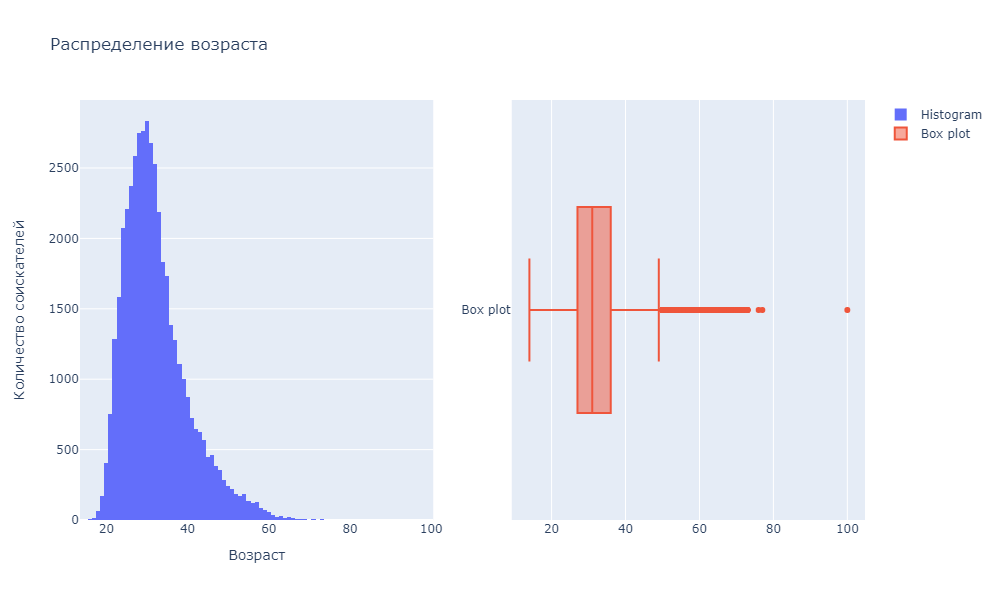

In [13]:
trace_his = go.Histogram(x=resume_hh['Возраст'], name="Histogram")
trace_box = go.Box(x=resume_hh['Возраст'], name="Box plot")
fig = make_subplots(rows=1, cols=2)
fig.add_trace(trace_his,row=1, col=1)
fig.add_trace(trace_box,row=1, col=2)
fig.update_layout(height=600,
                  width=1000,
                  title_text="Распределение возраста",
                  xaxis_title_text='Возраст',
                  yaxis_title_text='Количество соискателей'
                 )
fig.show('png')
fig.write_image('visualization/age_his.png')

Из распределения возраста соискателей видно, что наиболее часто встречающийся возраст составляет 30 лет, минимальный и максимальный возраст соискателей 14 и 100 лет соответственно, большая часть соискателей находится в возрастном диапазоне 27-36 лет. В распределении явно наблюдается аномалия - возрас соискателя 100 лет. Также видно, что число соискателей в возрасте более 60 лет составляет крайне малое значение, равно как возраст менее 18 лет.

2. Постройте распределение признака **"Опыт работы (месяц)"**. Опишите данное распределение, отвечая на следующие вопросы: чему равна мода распределения, каковы предельные значения признака, в каком примерном интервале находится опыт работы большинства соискателей? Есть ли аномалии для признака опыта работы, какие значения вы бы причислили к их числу?
*Совет: постройте гистограмму и коробчатую диаграмму рядом.*

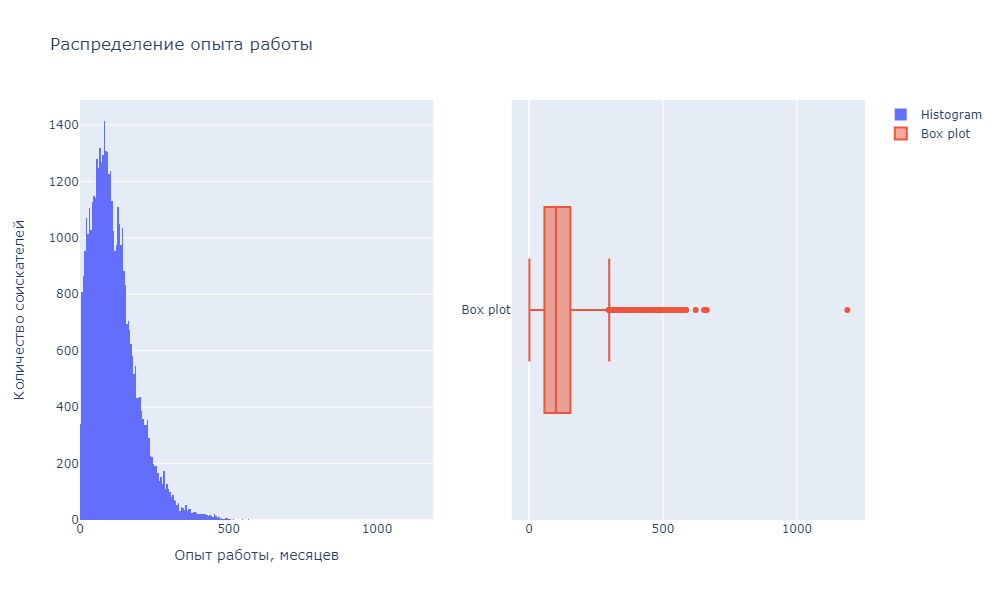

In [14]:
trace_his = go.Histogram(x=resume_hh['Опыт работы (месяц)'], name="Histogram")
trace_box = go.Box(x=resume_hh['Опыт работы (месяц)'], name="Box plot")
fig = make_subplots(rows=1, cols=2)
fig.add_trace(trace_his,row=1, col=1)
fig.add_trace(trace_box,row=1, col=2)
fig.update_layout(height=600,
                  width=1000,
                  title_text="Распределение опыта работы",
                  xaxis_title_text='Опыт работы, месяцев',
                  yaxis_title_text='Количество соискателей'
                 )
fig.show('png')
fig.write_image('visualization/exp_his.png')

Из распределения опыта работы соискателей видно, что наиболее часто встречающийся опыт составляет 81 месяц, минимальный и максимальный опыт соискателей 1 и 1188 месяцев соответственно, основная часть соискателей имеет опыт работы в диапазоне 50-180 месяцев. В распределении явно наблюдается аномалия - опыта работы соискателя 1188 месяцев (99 лет). Также видно, что опыт работы более 360 месяцев коррелируется с возрастом соискателей более 50 лет.

3. Постройте распределение признака **"ЗП (руб)"**. Опишите данное распределение, отвечая на следующие вопросы: каковы предельные значения признака, в каком примерном интервале находится заработная плата большинства соискателей? Есть ли аномалии для признака возраста? Обратите внимание на гигантские размеры желаемой заработной платы.
*Совет: постройте гистограмму и коробчатую диаграмму рядом.*


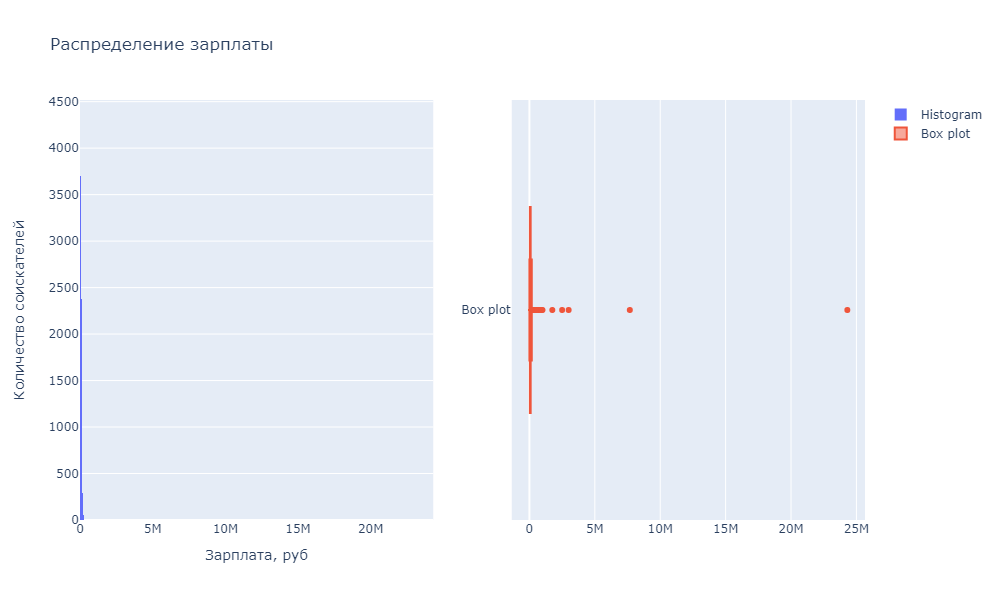

In [15]:
trace_his = go.Histogram(x=resume_hh['ЗП (руб)'], name="Histogram")
trace_box = go.Box(x=resume_hh['ЗП (руб)'], name="Box plot")
fig = make_subplots(rows=1, cols=2)
fig.add_trace(trace_his,row=1, col=1)
fig.add_trace(trace_box,row=1, col=2)
fig.update_layout(height=600,
                  width=1000,
                  title_text="Распределение зарплаты",
                  xaxis_title_text='Зарплата, руб',
                  yaxis_title_text='Количество соискателей'
                 )
fig.show('png')
fig.write_image('visualization/salary_his.png')

Из распределения зарплаты соискателей видно, что минимальная и максимальная зарплата соискателей составляет 1 руб. и 24,3 млн. руб. соответственно, заработная плата большинства соискателей  находится в интервале от 20К руб. до 100К руб. В распределении можно выделить аномалии - от 1 млн. руб. Также видно, что имеются как явно завышенные (гигантские) запросы 7.6 млн. руб, 24,3 млн. руб., так и явно заниженные запросы - 1 руб.

4. Постройте диаграмму, которая показывает зависимость **медианной** желаемой заработной платы (**"ЗП (руб)"**) от уровня образования (**"Образование"**). Используйте для диаграммы данные о резюме, где желаемая заработная плата меньше 1 млн рублей.
*Сделайте выводы по представленной диаграмме: для каких уровней образования наблюдаются наибольшие и наименьшие уровни желаемой заработной платы? Как вы считаете, важен ли признак уровня образования при прогнозировании заработной платы?*

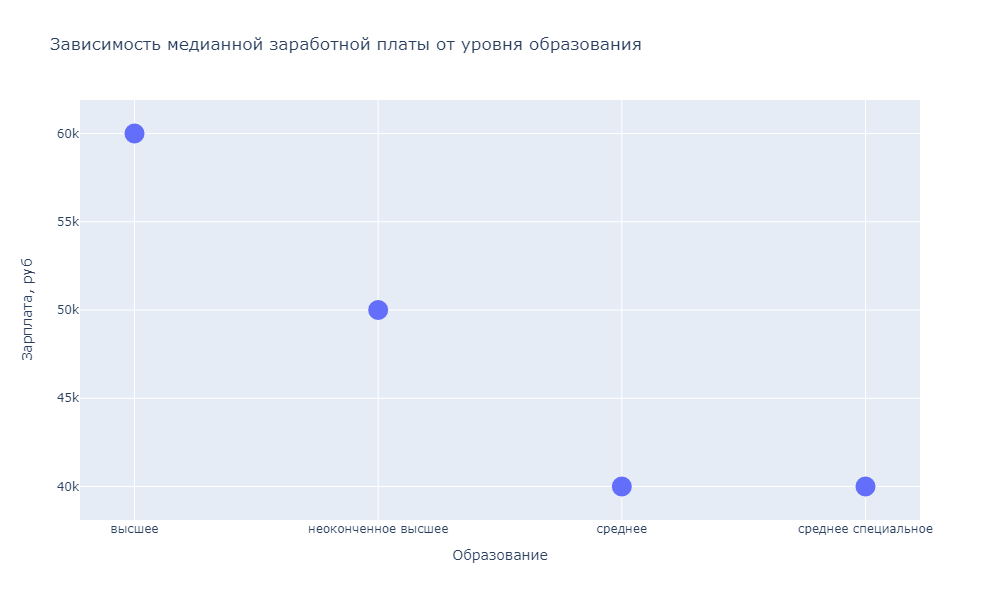

In [16]:
salary_edu = resume_hh[resume_hh['ЗП (руб)'] < 1000_000].groupby('Образование', as_index=False)['ЗП (руб)'].median()
fig = go.Figure()
fig.add_trace(go.Scatter(x=salary_edu['Образование'],
                         y=salary_edu['ЗП (руб)'],
                         mode='markers',
                         marker=dict(size=20)
                        )
             )
fig.update_layout(height=600,
                  width=1000,
                  title_text="Зависимость медианной заработной платы от уровня образования",
                  xaxis_title_text='Образование',
                  yaxis_title_text='Зарплата, руб'
                 )
fig.show('png')
fig.write_image('visualization/salary_edu_scat.png')

Из диаграмы видно, что уровень желаемой зарплаты зависит от образования, за исключением среднего и среднего специального, для которых уровень зарплаты одинаков. И соответственно чем выше образование, тем выше запрос зарплаты. Для высшего образования он максимален (60К руб.), для среднего и среднего специального он минимален (40К руб.). Поэтому уровень образования является важным признаком для прогнозирования зарплаты.

5. Постройте диаграмму, которая показывает распределение желаемой заработной платы (**"ЗП (руб)"**) в зависимости от города (**"Город"**). Используйте для диаграммы данные о резюме, где желая заработная плата меньше 1 млн рублей.
*Сделайте выводы по полученной диаграмме: как соотносятся медианные уровни желаемой заработной платы и их размах в городах? Как вы считаете, важен ли признак города при прогнозировании заработной платы?*

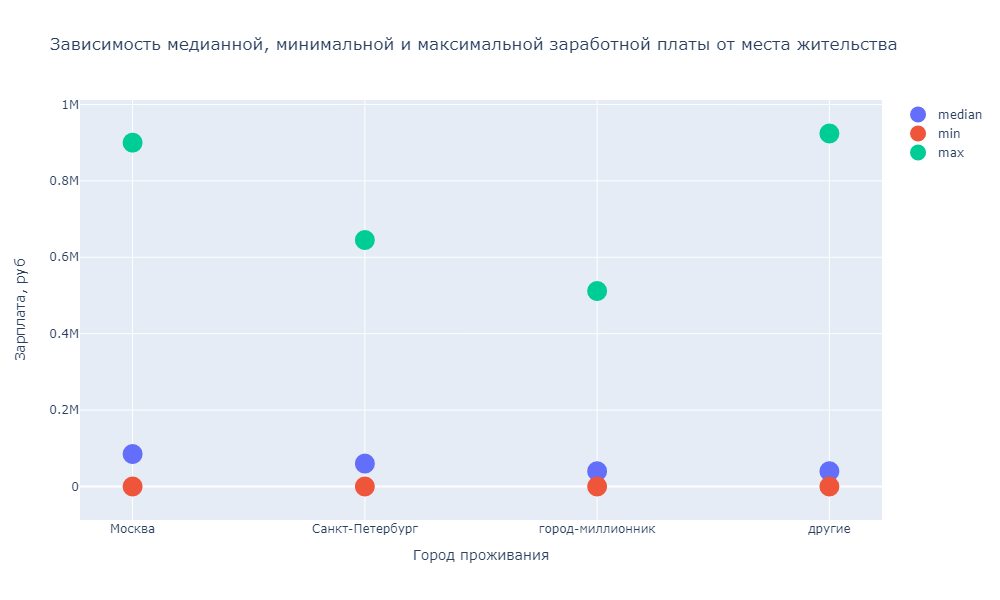

In [17]:
salary_city_median = resume_hh[resume_hh['ЗП (руб)'] < 1000_000].groupby('Город', as_index=False)['ЗП (руб)'].median()
salary_city_min = resume_hh[resume_hh['ЗП (руб)'] < 1000_000].groupby('Город', as_index=False)['ЗП (руб)'].min()
salary_city_max = resume_hh[resume_hh['ЗП (руб)'] < 1000_000].groupby('Город', as_index=False)['ЗП (руб)'].max()

fig = go.Figure()
fig.add_trace(go.Scatter(x=salary_city_median['Город'],
                         y=salary_city_median['ЗП (руб)'],
                         name='median',
                         mode='markers',
                         marker_size=20
                        )
             )
fig.add_trace(go.Scatter(x=salary_city_min['Город'],
                         y=salary_city_min['ЗП (руб)'],
                         name='min',
                         mode='markers',
                         marker_size=20
                        )
             )
fig.add_trace(go.Scatter(x=salary_city_max['Город'],
                         y=salary_city_max['ЗП (руб)'],
                         name='max',
                         mode='markers',
                         marker_size=20
                        )
             )
fig.update_layout(height=600,
                  width=1000,
                  title_text="Зависимость медианной, минимальной и максимальной заработной платы от места жительства",
                  xaxis_title_text='Город проживания',
                  yaxis_title_text='Зарплата, руб'
                 )
fig.show('png')
fig.write_image('visualization/salary_city_scat.png')

Из диаграмы видно, что уровень медианной желаемой зарплаты зависит от города проживания (в выбранной градации), за исключением городов-миллионников и других городов, для которых уровень зарплаты одинаков. Для Москвы он максимален (85К руб.), для городов-миллионников и других городов он минимален (40К руб.), Санкт-Петербург занимает промежуточное положение (60К руб.). Минимальные значения уровня зарплаты одинаковы во всех категориях и составляют 1 руб., а максимальные значения соответствуют тенденциям медианных значений, за исключением категории другие. Поэтому место проживания является важным признаком для прогнозирования зарплаты.

6. Постройте **многоуровневую столбчатую диаграмму**, которая показывает зависимость медианной заработной платы (**"ЗП (руб)"**) от признаков **"Готовность к переезду"** и **"Готовность к командировкам"**. Проанализируйте график, сравнив уровень заработной платы в категориях.

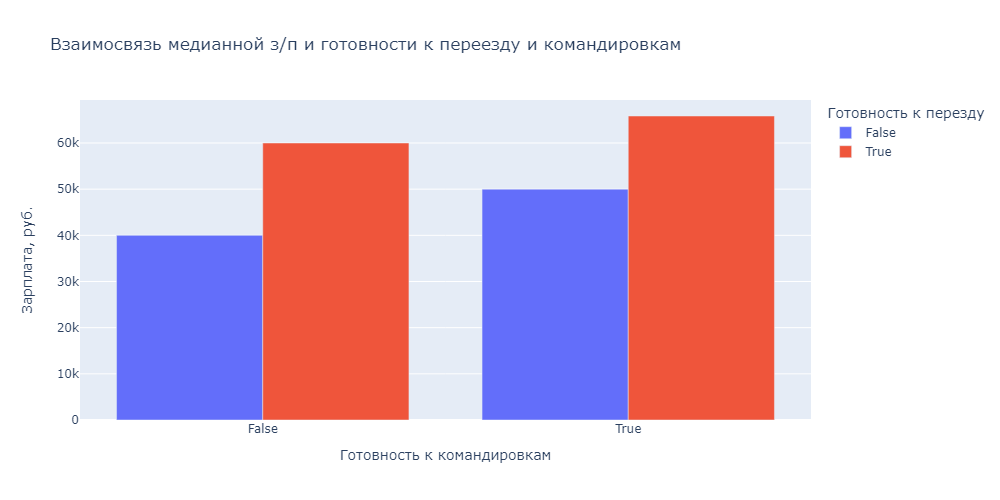

In [18]:
salary_redy = resume_hh.groupby(['Готовность к переезду', 'Готовность к командировкам'])['ЗП (руб)'].median().unstack()
#print(salary_redy)
fig = px.bar(
    data_frame=salary_redy,
    x=['False', 'True'],
    y=salary_redy.index,
    labels = {'x':'Готовность к командировкам', 'variable':'Готовность к перезду', 'value':'Зарплата, руб.'},
    barmode='group',
    height=500,
    width=1000,
    title='Взаимосвязь медианной з/п и готовности к переезду и командировкам'
)
fig.show('png')
fig.write_image('visualization/salary_redy_bar.png')

Из диаграммы видно, что готовность соискатедя к переезду, а также готовность к комндировкам увеличивает желаемую зарплату. Соответственно одновременная готовность и к переезду и к командировкам дает максимальное увеличение. Одновременно с этим, готовность к перезду дает большую прибавку к желаемой зарплате, чем готовность к командировкам. 

7. Постройте сводную таблицу, иллюстрирующую зависимость **медианной** желаемой заработной платы от возраста (**"Возраст"**) и образования (**"Образование"**). На полученной сводной таблице постройте **тепловую карту**. Проанализируйте тепловую карту, сравнив показатели внутри групп.

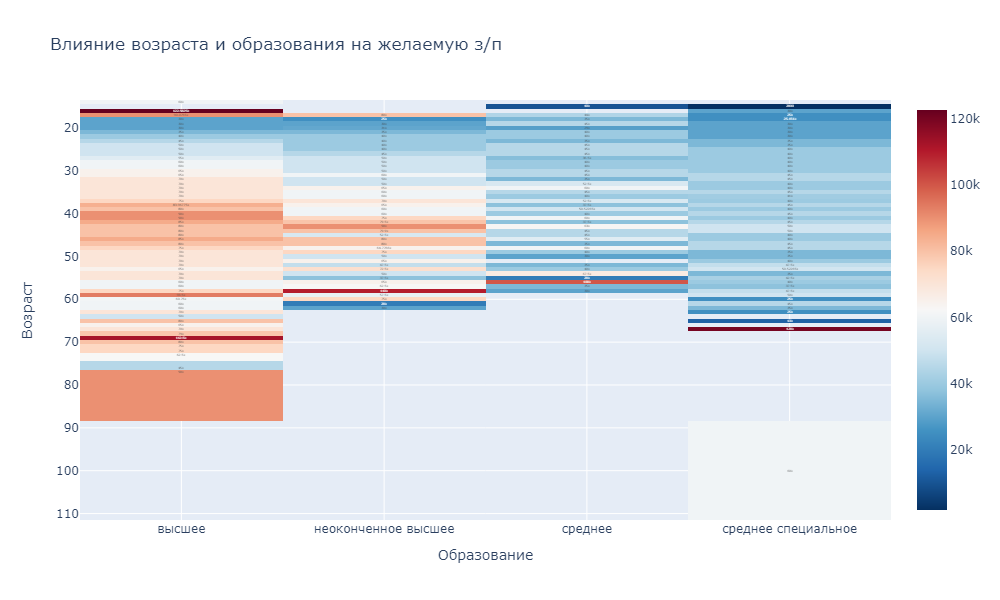

In [19]:
salary_age_edu = resume_hh.pivot_table(
    index='Возраст',
    columns='Образование',
    values='ЗП (руб)',
    aggfunc='median'
)
#display(salary_age_edu)
fig = px.imshow(salary_age_edu,
                text_auto=True,
                color_continuous_scale='RdBu_r',
                width = 1000,
                height = 600,
                title='Влияние возраста и образования на желаемую з/п'
)
fig.show('png')
fig.write_image('visualization/salary_age_edu_heat.png')

Как видно из диаграмы во всех категориях образования с возрастом растет желаемая зарплата, это нормальное явление, так как с возрастом растет и опыт, а с опытом и оплата. В категории высшее образование скорость роста ожидаемой зарплаты самая высокая, затем идет неоконченное высшее, затес среднее и только потом среднее специальное. В категории высшее образование люди хотят работать дольше и получать больше. В категории среднее специальное наблюдается аномалия - возраст соискателя 100 лет. 

8. Постройте **диаграмму рассеяния**, показывающую зависимость опыта работы (**"Опыт работы (месяц)"**) от возраста (**"Возраст"**). Опыт работы переведите из месяцев в года, чтобы признаки были в едином масштабе. Постройте на графике дополнительно прямую, проходящую через точки (0, 0) и (100, 100). Данная прямая соответствует значениям, когда опыт работы равен возрасту человека. Точки, лежащие на этой прямой и выше нее - аномалии в наших данных (опыт работы больше либо равен возрасту соискателя)

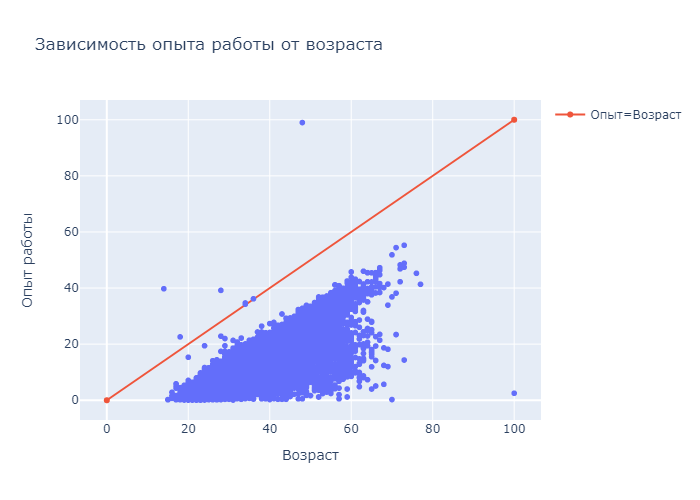

In [20]:
resume_hh['Опыт работы'] = resume_hh['Опыт работы (месяц)'] / 12
fig = px.scatter(resume_hh,
                 x='Возраст',
                 y='Опыт работы',
                 title='Зависимость опыта работы от возраста'
                 )
fig.add_trace(go.Scatter(x=[0,100], y=[0,100], name='Опыт=Возраст'))
fig.show('png')
fig.write_image('visualization/exp_age_scat.png')
resume_hh.drop('Опыт работы', axis=1, inplace=True)

Зависимость опыта от возраста носит естественный характер, с возрастом растет опыт. В возрасте более 60 лет появляется разреженность данных, это связано с резким уменьшением количества сосискателей в этом возрасте (выход на пенсию). 
Также из представленной диаграммы видно, что в данных имеются аномалии связанные с недостоверными данными об опыте работы (опыт работы больше возраста соискателя), таких записей 7шт.

**Дополнительные баллы**

Для получения 2 дополнительных баллов по разведывательному анализу постройте еще два любых содержательных графика или диаграммы, которые помогут проиллюстрировать влияние признаков/взаимосвязь между признаками/распределения признаков. Приведите выводы по ним. Желательно, чтобы в анализе участвовали признаки, которые мы создавали ранее в разделе "Преобразование данных".


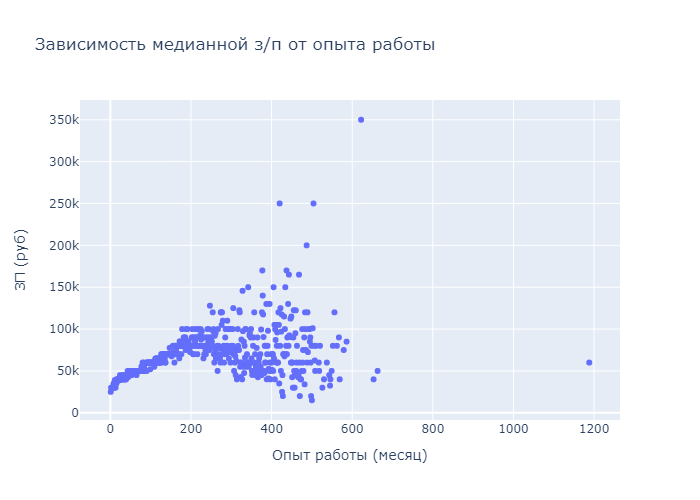

In [21]:
salary_exp = resume_hh.groupby(['Опыт работы (месяц)'], as_index=False)['ЗП (руб)'].median()
#display(salary_exp)
fig = px.scatter(salary_exp,
                 x='Опыт работы (месяц)',
                 y='ЗП (руб)',
                 title='Зависимость медианной з/п от опыта работы'
                 )
fig.show('png')
fig.write_image('visualization/salary_exp_scat.png')

Из распределения виден однозначный рост желаемой зарплаты с ростом опыта работы до значения приблизительно 18-20 лет. Далее несмотря на то, что наблюдается выраженный конгламерат на снижение зарплаты с ростом опыта, также наблюдается рассеяный тренд на увеличение зарплаты с ростом опыта. Это в принципе объяснимо, так как 18-20 лет работы это, как правило, пик проффесиональной карьеры, далее все индивидуально. Также на диаграме наблюдаются аномалии - очень большой опыт работы.

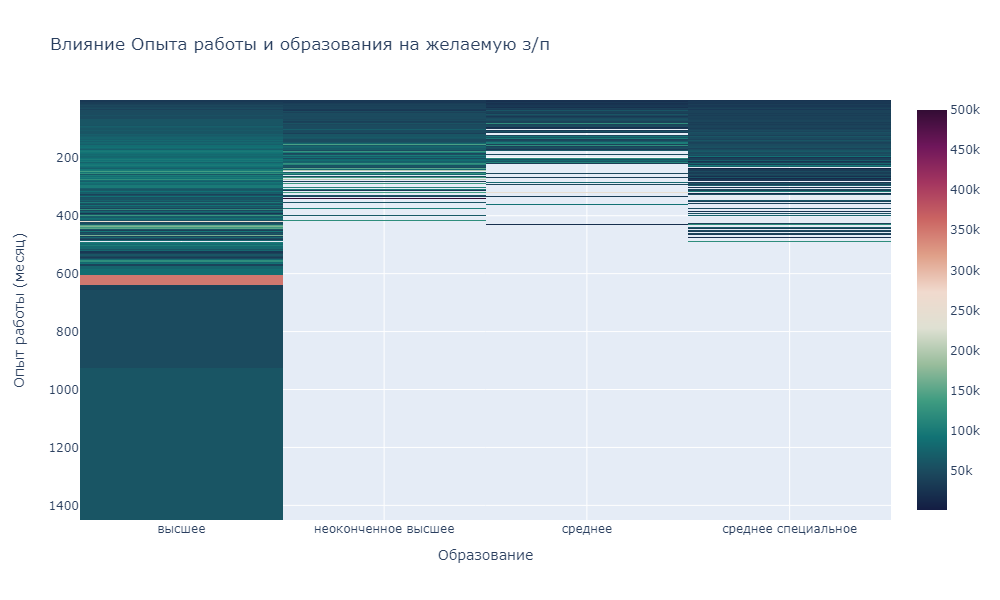

In [22]:
salary_exp_edu = resume_hh.pivot_table(
    index='Опыт работы (месяц)',
    columns='Образование',
    values='ЗП (руб)',
    aggfunc='median'
)

fig = px.imshow(salary_exp_edu,
                text_auto=True,
                color_continuous_scale='curl',
                width = 1000,
                height = 600,
                title='Влияние Опыта работы и образования на желаемую з/п'
)
fig.show('png')
fig.write_image('visualization/salary_exp_edu_heat.png')

Как видно из диаграмы во всех категориях образования с опытом растет желаемая зарплата до определенного значения опыта, но в категории высшее образование он достигает своего пика позже, чем в других категориях.

# Очистка данных

1. Начнем с дубликатов в наших данных. Найдите **полные дубликаты** в таблице с резюме и удалите их. 

In [23]:
mask = resume_hh.duplicated()
resume_hh_duplicates = resume_hh[mask]
print(f'Число найденных дубликатов: {resume_hh_duplicates.shape[0]}')
resume_hh = resume_hh.drop_duplicates()
print(f'Результирующее число записей: {resume_hh.shape[0]}')

Число найденных дубликатов: 161
Результирующее число записей: 44583


2. Займемся пропусками. Выведите информацию **о числе пропусков** в столбцах. 

In [24]:
resume_hh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44583 entries, 0 to 44743
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Ищет работу на должность:        44583 non-null  object        
 1   Последнее/нынешнее место работы  44582 non-null  object        
 2   Последняя/нынешняя должность     44581 non-null  object        
 3   Обновление резюме                44583 non-null  datetime64[ns]
 4   Авто                             44583 non-null  object        
 5   Образование                      44583 non-null  object        
 6   Пол                              44583 non-null  object        
 7   Возраст                          44583 non-null  int64         
 8   Опыт работы (месяц)              44415 non-null  float64       
 9   Город                            44583 non-null  object        
 10  Готовность к переезду            44583 non-null  bool          

3. Итак, у нас есть пропуски в 3ех столбцах: **"Опыт работы (месяц)"**, **"Последнее/нынешнее место работы"**, **"Последняя/нынешняя должность"**. Поступим следующим образом: удалите строки, где есть пропуск в столбцах с местом работы и должностью. Пропуски в столбце с опытом работы заполните **медианным** значением.

In [25]:
# Заполняем пропуски в 'Опыт работы (месяц)' медианой
resume_hh['Опыт работы (месяц)'] = resume_hh['Опыт работы (месяц)'].fillna(resume_hh['Опыт работы (месяц)'].median())
#удаляем записи, в которых есть хотя бы 1 пропуск
resume_hh = resume_hh.dropna(how='any', axis=0)
display(resume_hh.info())
print(f'среднее значение в столбце "Опыт работы (месяц)": {round(resume_hh["Опыт работы (месяц)"].mean(), 0)} месяцев')

<class 'pandas.core.frame.DataFrame'>
Index: 44581 entries, 0 to 44743
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Ищет работу на должность:        44581 non-null  object        
 1   Последнее/нынешнее место работы  44581 non-null  object        
 2   Последняя/нынешняя должность     44581 non-null  object        
 3   Обновление резюме                44581 non-null  datetime64[ns]
 4   Авто                             44581 non-null  object        
 5   Образование                      44581 non-null  object        
 6   Пол                              44581 non-null  object        
 7   Возраст                          44581 non-null  int64         
 8   Опыт работы (месяц)              44581 non-null  float64       
 9   Город                            44581 non-null  object        
 10  Готовность к переезду            44581 non-null  bool          

None

среднее значение в столбце "Опыт работы (месяц)": 114.0 месяцев


4. Мы добрались до ликвидации выбросов. Сначала очистим данные вручную. Удалите резюме, в которых указана заработная плата либо выше 1 млн. рублей, либо ниже 1 тыс. рублей.

In [26]:
resume_hh = resume_hh.loc[(resume_hh['ЗП (руб)'] <= 1000_000) & (resume_hh['ЗП (руб)'] >= 1000)]
display(resume_hh.info())

<class 'pandas.core.frame.DataFrame'>
Index: 44492 entries, 0 to 44743
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Ищет работу на должность:        44492 non-null  object        
 1   Последнее/нынешнее место работы  44492 non-null  object        
 2   Последняя/нынешняя должность     44492 non-null  object        
 3   Обновление резюме                44492 non-null  datetime64[ns]
 4   Авто                             44492 non-null  object        
 5   Образование                      44492 non-null  object        
 6   Пол                              44492 non-null  object        
 7   Возраст                          44492 non-null  int64         
 8   Опыт работы (месяц)              44492 non-null  float64       
 9   Город                            44492 non-null  object        
 10  Готовность к переезду            44492 non-null  bool          

None

5. В процессе разведывательного анализа мы обнаружили резюме, в которых **опыт работы в годах превышал возраст соискателя**. Найдите такие резюме и удалите их из данных


In [27]:
resume_hh = resume_hh.loc[(resume_hh['Опыт работы (месяц)'] / 12) < resume_hh['Возраст']]
display(resume_hh.info())

<class 'pandas.core.frame.DataFrame'>
Index: 44485 entries, 0 to 44743
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Ищет работу на должность:        44485 non-null  object        
 1   Последнее/нынешнее место работы  44485 non-null  object        
 2   Последняя/нынешняя должность     44485 non-null  object        
 3   Обновление резюме                44485 non-null  datetime64[ns]
 4   Авто                             44485 non-null  object        
 5   Образование                      44485 non-null  object        
 6   Пол                              44485 non-null  object        
 7   Возраст                          44485 non-null  int64         
 8   Опыт работы (месяц)              44485 non-null  float64       
 9   Город                            44485 non-null  object        
 10  Готовность к переезду            44485 non-null  bool          

None

6. В результате анализа мы обнаружили потенциальные выбросы в признаке **"Возраст"**. Это оказались резюме людей чересчур преклонного возраста для поиска работы. Попробуйте построить распределение признака в **логарифмическом масштабе**. Добавьте к графику линии, отображающие **среднее и границы интервала метода трех сигм**. Напомним, сделать это можно с помощью метода axvline. Например, для построение линии среднего будет иметь вид:

`histplot.axvline(log_age.mean(), color='k', lw=2)`

В какую сторону асимметрично логарифмическое распределение? Напишите об этом в комментарии к графику.
Найдите выбросы с помощью метода z-отклонения и удалите их из данных, используйте логарифмический масштаб. Давайте сделаем послабление на **1 сигму** (возьмите 4 сигмы) в **правую сторону**.

Выведите таблицу с полученными выбросами и оцените, с каким возрастом соискатели попадают под категорию выбросов?

Численный показатель ассиметрии: 0.4523422276053838


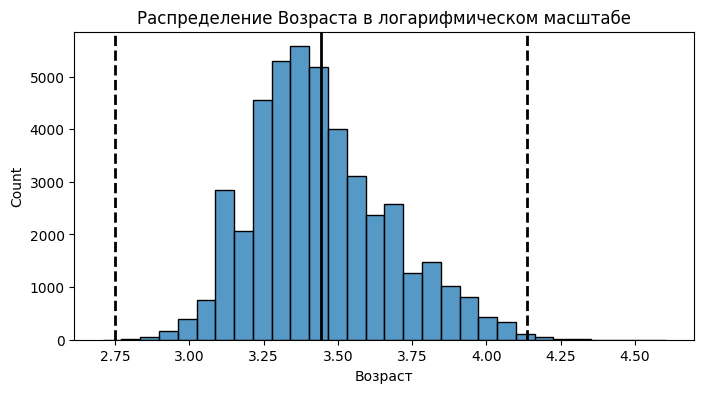

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_age = np.log(resume_hh['Возраст'])
print(f'Численный показатель ассиметрии: {log_age.skew()}')
histplot = sns.histplot(log_age, bins=30, ax=ax)
histplot.axvline(log_age.mean(), color='k', lw=2)
histplot.axvline(log_age.mean()+ 3 * log_age.std(), color='k', ls='--', lw=2)
histplot.axvline(log_age.mean()- 3 * log_age.std(), color='k', ls='--', lw=2)
histplot.set_title('Распределение Возраста в логарифмическом масштабе');



Данное распределение является правосторонним, т.к. показатель ассиметрии равен 0.45. С правой стороны наблюдаются единичные выбросы (z-отклонение 3 $\sigma$)

In [29]:
outliers, resume_hh = outliers_z_score_mod(resume_hh, 'Возраст', log_scale=True, right=4)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {resume_hh.shape[0]}')
display(outliers)

Число выбросов по методу z-отклонения: 3
Результирующее число записей: 44482


,Ищет работу на должность:,Последнее/нынешнее место работы,Последняя/нынешняя должность,Обновление резюме,Авто,Образование,Пол,Возраст,Опыт работы (месяц),Город,...,волонтерство,проектная работа,полная занятость,частичная занятость,вахтовый метод,гибкий график,полный день,сменный график,удаленная работа,ЗП (руб)
31137,Менеджер по работе с клиентами,"ООО ""ФёрстКэшКомпани""",Менеджер по работе с клиентами,2019-04-06,Не указано,среднее,М,15,2.0,Санкт-Петербург,...,False,False,False,True,False,True,False,True,True,10000.0
32950,Тестировщик игр,OOO ЖМЫХ,Тестировщик ПО,2019-04-09,Не указано,среднее специальное,М,15,3.0,другие,...,False,False,True,False,False,False,True,False,False,2000.0
33654,Frontend-разработчик,Freelance,Frontend-разработчик,2019-04-19,Не указано,среднее специальное,М,100,30.0,Санкт-Петербург,...,False,True,True,True,False,True,True,False,True,60000.0
